<a href="https://colab.research.google.com/github/luizfgiatti/ML_Amazon_Project/blob/main/Amazon_Sentiment_Classification_Final_Luiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Sentiment Classification using DistilBERT


This notebook implements a sentiment classifier using a fine-tuned DistilBERT model with weighted loss to handle class imbalance.
We also export results to `.csv` and prepare the output for Business Intelligence tools like Power BI or Tableau.


## 1. Install Required Libraries

In [2]:

!pip install -q transformers datasets gradio scikit-learn pandas matplotlib seaborn


## 2. Load and Prepare the Dataset

In [3]:

from google.colab import files
uploaded = files.upload()  # Upload amazon_reviews_clean.csv manually

import pandas as pd

df = pd.read_csv("amazon_reviews_clean.csv")
df = df[["clean_text", "sentiment"]]
df = df.dropna()


Saving amazon_reviews_clean.csv to amazon_reviews_clean.csv


## 3. Visualize Sentiment Distribution

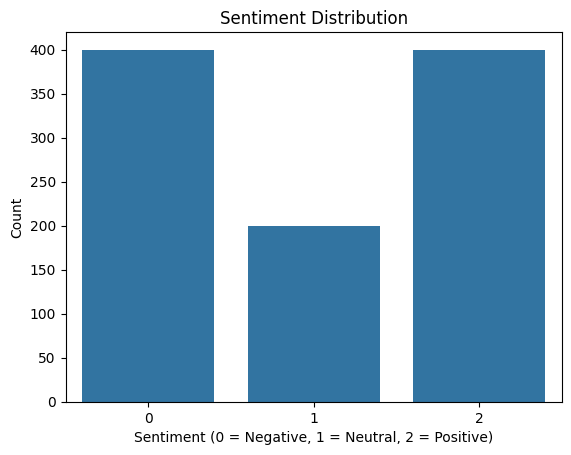

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0 = Negative, 1 = Neutral, 2 = Positive)")
plt.ylabel("Count")
plt.show()


## 4. Train-Test Split

In [5]:

from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Tokenization using DistilBERT

In [6]:

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## 6. Create Custom Dataset Class

In [7]:

import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())


## 7. Define Weighted Loss Trainer

In [8]:

from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weights_tensor = torch.tensor([1.0, 2.0, 2.5]).to(logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


## 8. Train the Model with Weighted Loss

In [10]:
from transformers import DistilBertForSequenceClassification, TrainingArguments
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch

# Define custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # <-- aceita kwargs agora
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Define class weights (adjust if needed)
        weights_tensor = torch.tensor([1.0, 2.0, 2.5]).to(logits.device)
        loss_fn = CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Load model with correct number of labels
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# Define training arguments (clean and wandb disabled)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    report_to="none"  # <-- correto para desativar wandb
)

# Initialize trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=250, training_loss=1.0082290649414063, metrics={'train_runtime': 19.2327, 'train_samples_per_second': 207.979, 'train_steps_per_second': 12.999, 'total_flos': 7244440056000.0, 'train_loss': 1.0082290649414063, 'epoch': 5.0})

## 9. Evaluate the Model

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.00      0.00      0.00        39
           2       0.38      1.00      0.55        75

    accuracy                           0.38       200
   macro avg       0.12      0.33      0.18       200
weighted avg       0.14      0.38      0.20       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


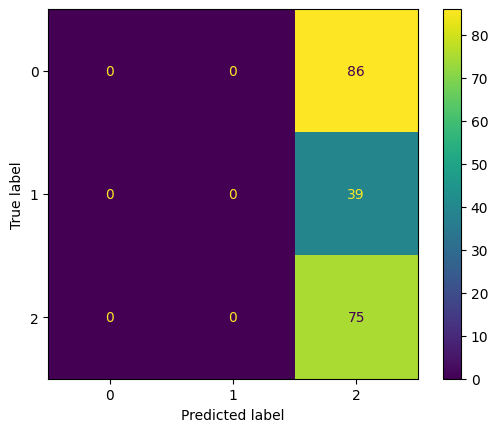

In [11]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## 10. Export Predictions to CSV

In [12]:

X_test_texts = list(X_test)
y_pred_labels = y_pred
y_test_labels = y_test.tolist()

df_results = pd.DataFrame({
    "review": X_test_texts,
    "true_sentiment": y_test_labels,
    "predicted_sentiment": y_pred_labels
})

df_results.to_csv("predictions.csv", index=False)
df_results.head()


,review,true_sentiment,predicted_sentiment
0,great product!,1,2
1,great product!,2,2
2,great product!,0,2
3,not what i expected.,0,2
4,not what i expected.,1,2


## 11. Connect to Power BI or Tableau


Use the exported file `predictions.csv` to build dashboards in BI tools.

You can create:
- Sentiment by Product Category (if category exists)
- True vs. Predicted comparison
- Misclassifications and trends

**Steps:**
1. Open Power BI or Tableau
2. Load `predictions.csv`
3. Use charts like:
   - Confusion matrix using `true_sentiment` vs `predicted_sentiment`
   - Pie chart of `predicted_sentiment`
   - Bar chart of `sentiment` by product category (if added)
